Dataset1: https://www.kaggle.com/pranavraikokte/covid19-image-dataset


<h3><a href='https://www.kaggle.com/pranavraikokte/covid19-image-dataset'>Dataset</h3>
    

# Import Libraries & Modules

In [1]:
import torchvision
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.manual_seed(0)

### transform

In [2]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Load Dataset and read images 

In [3]:
train_data = torchvision.datasets.ImageFolder('../datasets/Covid19-dataset/train',
                                             transform=train_transform)
test_data = torchvision.datasets.ImageFolder('../datasets/Covid19-dataset/test',
                                            transform=test_transform)

In [4]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 42
Number of test batches 11


### Show Images

In [5]:
class_names = train_data.classes

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

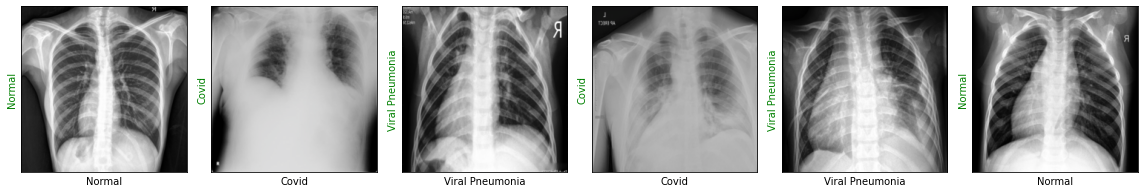

In [8]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

In [8]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

### Create model Resnet(18layer)

In [6]:
resnet18 = torchvision.models.resnet18(pretrained = True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
#hyperparameters
in_features = 512
out_features = 3
lr = 3e-5

resnet18.fc = torch.nn.Linear(in_features=in_features, out_features=out_features)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr = lr) #lr=0.00003

In [22]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

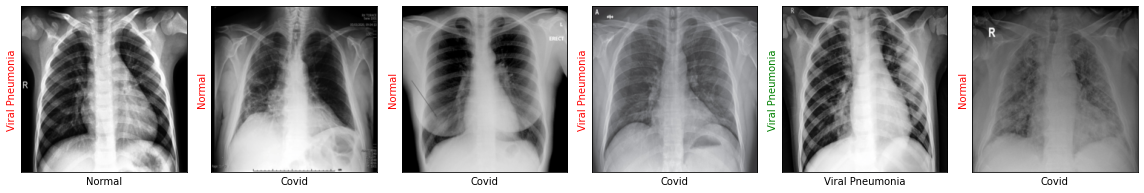

In [23]:
show_preds()

In [13]:
def train(epochs):
    print('Starting training...')
    for e in range(epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_data)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training...
Starting epoch 1/3
Evaluating at step 0
Validation Loss: 1.1206, Accuracy: 0.3788


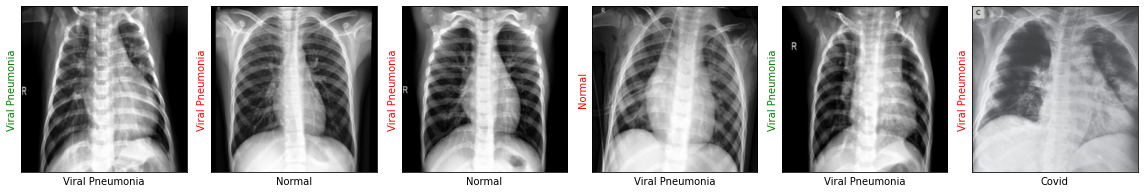

Evaluating at step 20
Validation Loss: 0.8906, Accuracy: 0.6515


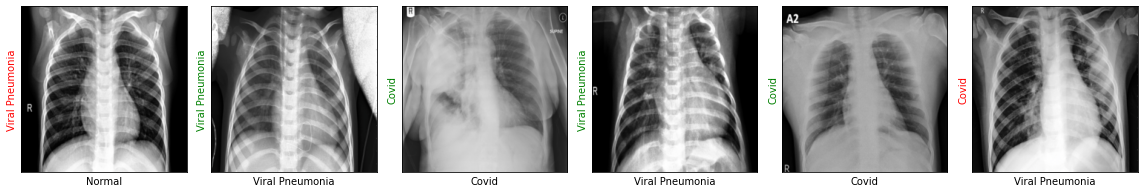

Evaluating at step 40
Validation Loss: 0.4876, Accuracy: 0.8788


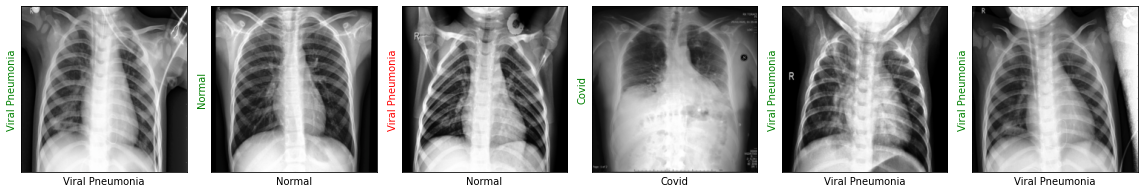

Training Loss: 0.6106
Starting epoch 2/3
Evaluating at step 0
Validation Loss: 0.4104, Accuracy: 0.8788


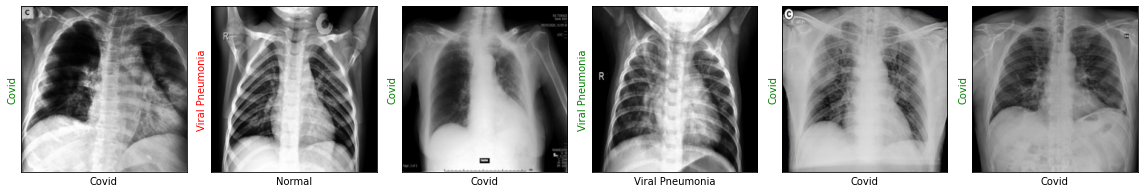

Evaluating at step 20
Validation Loss: 0.2704, Accuracy: 0.9242


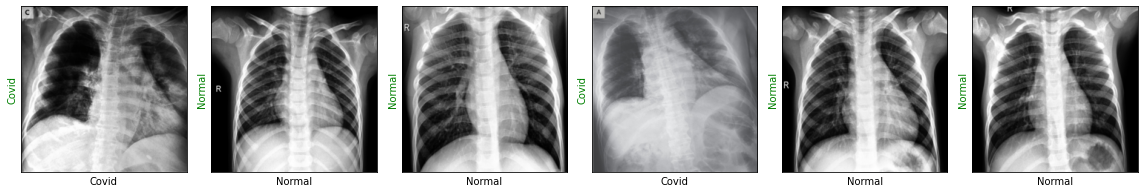

Evaluating at step 40
Validation Loss: 0.1920, Accuracy: 0.9848


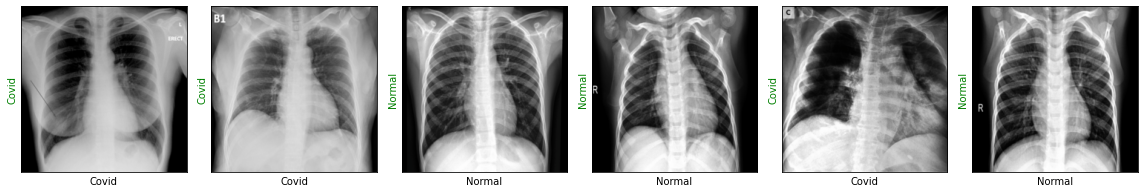

Performance condition satisfied, stopping..
Wall time: 2min 3s


In [14]:
%%time

train(epochs=3)

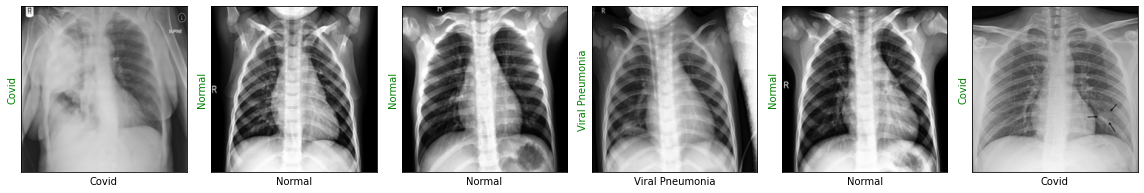

In [15]:
show_preds()